In [3]:
# import sys
# import numpy as np
# import pandas as pd
# sys.path.append("../../Utils")
# from loaders import HNSCCFeatureHandler

# METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW_v10.csv"
# VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
# HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

# # Load corrected features
# hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
# _ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
# _ = hc_data.normalize_zscore()
# _ = hc_data.merge_feature_metadata()
# _ = hc_data.batch_correct()

# responder = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids))
# non_responder = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids))
# combined = pd.concat([responder, non_responder], axis=0)

# combined_long = combined.reset_index().melt(id_vars='index', var_name='region', value_name='value')
# combined_long.rename(columns={'index': 'sample'}, inplace=True)
# split = combined_long['region'].str.extract(r'(chr[^:]+):(\d+)-(\d+)')
# split.columns = ['chrom', 'start', 'end']
# bed_corrected = pd.concat([split, combined_long[['sample', 'value']]], axis=1)
# bed_corrected['start'] = bed_corrected['start'].astype(int)
# bed_corrected['end'] = bed_corrected['end'].astype(int)

# bed_corrected_pivot = bed_corrected.pivot_table(
#     index=['chrom', 'start', 'end'],
#     columns='sample',
#     values='value'
# ).reset_index()

# bed_corrected_pivot.to_csv("combined_corrected_10.bed", sep="\t", index=False, header=True)

# # Metadata export
# age = hc_data.get_metadata_col("Age")
# ogid = hc_data.get_metadata_col("OGID")
# gender = hc_data.get_metadata_col("Gender")
# smoking = hc_data.get_metadata_col("Smoking")
# alcohol = hc_data.get_metadata_col("Alcohol")
# ethnicity = hc_data.get_metadata_col("Ethnicity")
# race = hc_data.get_metadata_col("Race")
# diagnosis = hc_data.get_metadata_col("Diagnosis")
# type_of_visit = hc_data.get_metadata_col("Type of Visit")
# treatment_response = hc_data.get_metadata_col("Treatment Response")

# metadata = pd.concat([
#     ogid, age, gender, smoking, alcohol,
#     diagnosis, ethnicity, race, hpv, stratification, type_of_visit, treatment_response
# ], axis=1)

# samples = bed_corrected_pivot.columns[3:]
# metadata.loc[samples].to_csv("combined_covariates_10.csv", index=True, header=True)

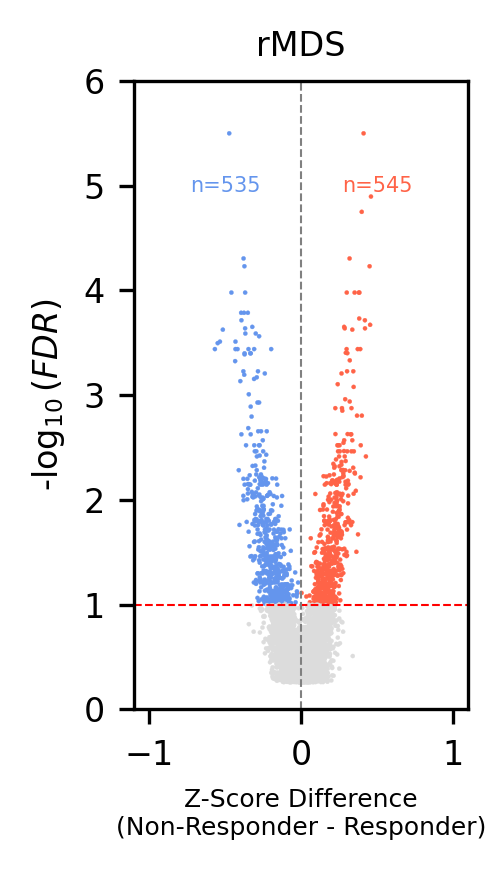

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the prepared CSV from R
vol_df = pd.read_csv("F3A.csv")
vol_df['NegLog10PValue'] = -np.log10(vol_df['qval'])
vol_df['meanDiff'] = vol_df['meanDiff'] * -1
# Assign colors
threshold = 0.1
threshold_log = -np.log10(threshold)
vol_df['Color'] = 'gainsboro'
vol_df.loc[(vol_df['qval'] < threshold) & (vol_df['meanDiff'] > 0), 'Color'] = 'tomato'
vol_df.loc[(vol_df['qval'] < threshold) & (vol_df['meanDiff'] < 0), 'Color'] = 'cornflowerblue'

# Create volcano plot
fig, ax = plt.subplots(figsize=(1.76, 3.0), dpi=300)
sns.scatterplot(
    data=vol_df,
    x='meanDiff',
    y='NegLog10PValue',
    hue='Color',
    palette={'cornflowerblue': 'cornflowerblue', 'tomato': 'tomato', 'gainsboro': 'gainsboro'},
    edgecolor=None,
    s=1,
    ax=ax
)

# Add lines and labels
ax.axhline(threshold_log, color='red', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Z-Score Difference\n(Non-Responder - Responder)', fontsize=6)
ax.set_ylabel(r'-$\log_{10}(FDR)$', fontsize=8)
ax.set_title('rMDS', fontsize=8)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 6)
ax.tick_params(axis='both', labelsize=8)
ax.legend().remove()

# Extract significant region names
significant_df = vol_df[vol_df['qval'] < threshold]
significant_indices = significant_df['region'].tolist() if 'region' in vol_df.columns else vol_df.index[vol_df['qval'] < threshold].tolist()

# Count up and down
n_up = significant_df[significant_df['meanDiff'] > 0].shape[0]
n_down = significant_df[significant_df['meanDiff'] < 0].shape[0]
ax.text(0.5, 5, f"n={n_up}", color='tomato', fontsize=5, ha='center', va='center')
ax.text(-0.5, 5, f"n={n_down}", color='cornflowerblue', fontsize=5, ha='center', va='center')

plt.tight_layout()
plt.savefig('F3A.rMDS.v1.pdf', dpi=1000)